In [1]:
def fourier_transform_2(g):
    from pyzx.utils import EdgeType, VertexType
    del_e = []
    del_v = []
    add_e = []
    types = g.types()
    phases = g.phases()
    es = list(g.edges())
    vs = list(g.vertices())

    for v in vs:
        arity = len(g.neighbors(v))
        if types[v] == VertexType.H_BOX and arity == 2 and phases[v] != 1:
            phase = phases[v]
            v1,v2 = g.neighbors(v)
            c = g.add_vertex(VertexType.Z)
            vh1 = g.add_vertex(VertexType.H_BOX)
            vh2 = g.add_vertex(VertexType.H_BOX)
            ch1 = g.add_vertex(VertexType.H_BOX)
            c2 = g.add_vertex(VertexType.Z)
            ch2 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh1))
            add_e.append(g.edge(v2, vh2))
            add_e.append(g.edge(vh1, c))
            add_e.append(g.edge(vh2, c))
            add_e.append(g.edge(c, ch1))
            add_e.append(g.edge(ch1, c2))
            add_e.append(g.edge(c2, ch2))
            g.set_phase(ch2, phase*(-1/2))
            g.set_phase(v1, phases[v1]+phase*1/2)
            g.set_phase(v2, phases[v2]+phase*1/2)
            g.scalar.add_float(1/2)
            del_v.append(v)
            del_e.append(g.edge(v,v1))
            del_e.append(g.edge(v,v2))


    g.add_edges(add_e)
    g.remove_edges(del_e)
    for v in del_v:
        g.remove_vertex(v)

def fourier_transform_3(g):
    from pyzx.utils import EdgeType, VertexType
    del_e = []
    del_v = []
    add_e = []
    types = g.types()
    phases = g.phases()
    es = list(g.edges())
    vs = list(g.vertices())

    for v in vs:
        arity = len(g.neighbors(v))
        if types[v] == VertexType.H_BOX and arity == 3:
            phase = phases[v]
            v1,v2,v3 = g.neighbors(v)
            c = g.add_vertex(VertexType.Z)
            vh1 = g.add_vertex(VertexType.H_BOX)
            vh2 = g.add_vertex(VertexType.H_BOX)
            vh3 = g.add_vertex(VertexType.H_BOX)
            ch1 = g.add_vertex(VertexType.H_BOX)
            c2 = g.add_vertex(VertexType.Z)
            ch2 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh1))
            add_e.append(g.edge(v2, vh2))
            add_e.append(g.edge(v3, vh3))
            add_e.append(g.edge(vh1, c))
            add_e.append(g.edge(vh2, c))
            add_e.append(g.edge(vh3, c))
            add_e.append(g.edge(c, ch1))
            add_e.append(g.edge(ch1, c2))
            add_e.append(g.edge(c2, ch2))
            vh12 = g.add_vertex(VertexType.H_BOX)
            vh23 = g.add_vertex(VertexType.H_BOX)
            vh31 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh12))
            add_e.append(g.edge(vh12, v2))
            add_e.append(g.edge(v2, vh23))
            add_e.append(g.edge(vh23, v3))
            add_e.append(g.edge(v3, vh31))
            add_e.append(g.edge(vh31, v1))
            g.set_phase(ch2, phase*(1/4) )
            g.set_phase(vh12, phase*(1/2))
            g.set_phase(vh23, phase*(1/2) )
            g.set_phase(vh31, phase*(1/2) )
            g.set_phase(v1, phases[v1]-phase*1/4)
            g.set_phase(v2, phases[v2]-phase*1/4)
            g.set_phase(v3, phases[v3]-phase*1/4)
            g.scalar.add_float(1/2)
            del_v.append(v)
            del_e.append(g.edge(v,v1))
            del_e.append(g.edge(v,v2))
            del_e.append(g.edge(v,v3))


    g.add_edges(add_e)
    g.remove_edges(del_e)
    for v in del_v:
        g.remove_vertex(v)

# Benchmark: `Quimb` vs `ZX+Quimb`

Class for generating different types of random quantum circuits. We generate the ZX graph for the circuits which will then be contracted using optimization strategies and quimb's tensor contraction framework.

In [2]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import pyzx as zx
import time, random
from typing import List
class CircuitGenerator:
    def __init__(self, qubits: int = 5, depth: int = 10, circuit_type: str = 'clifford+T'):
        assert qubits > 0, "The number of qubits must be positive."
        assert depth > 0, "The depth must be positive."
        self.__qubits = qubits
        self.__depth = depth
        self.__circuit_type = circuit_type
    
    def __call__(self) -> zx.Graph:
        if self.__circuit_type == 'CNOT_HAD_PHASE':
            return zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits,
                                                      depth = self.__depth,
                                                      clifford = False).to_graph()
        elif self.__circuit_type == 'clifford+T':
            return zx.generate.cliffordT(qubits = self.__qubits,
                                                      depth = self.__depth)
        else:
            raise ValueError("The circuit type is not valid.")

Class for comparing contraction runtimes of vanilla quimb and quimb+zx. 

In [22]:
class CircuitBenchmark():
    def __init__(self, n: int, circuit_types: List[str]):
        self.__n = n
        self.__circuit_types = circuit_types

    def run_with_qubits(self,circuit_type, depth, qubits_range):
        zx_times, quimb_times = [], []
        self.__depth = depth
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(qubits=qubits, depth=depth, circuit_type=circuit_type )
            zx_time, quimb_time = self.__run_tensors()
            zx_times.append(zx_time)
            quimb_times.append(quimb_time)
        return zx_times, quimb_times

    def run_with_depths(self,circuit_type, qubits, depth_range):
        zx_times, quimb_times = [], []
        self.__qubits = qubits
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(qubits=qubits, depth=depth, circuit_type=circuit_type )
            zx_time, quimb_time = self.__run_tensors()
            zx_times.append(zx_time)
            quimb_times.append(quimb_time)
        return zx_times, quimb_times

    def __contract_quimb(self, g):
        while True:
            tensor = zx.to_quimb_tensor(g)
            try:
                tensor.full_simplify_('ADCSR',output_inds=())
                break
            except Exception as e:
                print(e)
                continue
        tensor = tensor.contract(output_inds = (),backend='jax')
        return tensor

    def __optimize_graph(self, g):
        # zx.full_reduce(g)
        zx.simplify.simulated_annealing_simp(g, cap=-20, iterations=100, quiet=True)
        zx.hsimplify.new_simp(g,quiet=True)
        fourier_transform_3(g)
        zx.hsimplify.par_hbox_simp(g,quiet=True)
        fourier_transform_2(g)
        
        return g

    def __run_tensor(self):
        g = self.__generator()
        g.apply_state("0"*self.__qubits)
        g.apply_effect("0"*self.__qubits)
        zx.to_gh(g)

        t = time.time()
        quimb_tn = self.__contract_quimb(g)
        quimb_time = time.time() - t

        g = self.__optimize_graph(g)
        t = time.time()
        zx_tensor = self.__contract_quimb(g)
        zx_time = time.time() - t

        if abs(quimb_tn)==0 or abs(zx_tensor)==0:
            return
        if abs(abs(quimb_tn)-abs(zx_tensor))/abs(zx_tensor) > 1e-3:
            # print("Error:", abs(abs(quimb_tn)-abs(zx_tensor))/abs(zx_tensor))
            # print("Rerunning...")
            self.__run_tensor()
        else: 
            self.__zx_times.append(zx_time)
            self.__quimb_times.append(quimb_time)
    
    def __run_tensors(self):
        self.__zx_times = []
        self.__quimb_times = []
        for _ in range(self.__n):
            self.__run_tensor()
        return (np.mean(self.__zx_times), np.mean(self.__quimb_times))

    def display_plot(self,circuit_type, zx_times, quimb_times, range, varying: str = 'qubits'):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if varying=='qubits' else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        ax.plot(range, zx_times, label = "quimb+ZX")
        ax.plot(range, quimb_times, label = "quimb")
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(
            " {} from {} to {} {}, fixed {} of {}".format(
                circuit_type, range[0], range[-1], var_type, fixed_type, fixed_quant
            )
        )
        ax.legend()

    def test(self, varying: str, fixed_quant: int, range):
        for circuit_type in self.__circuit_types:
            zx_times, quimb_times = self.run_with_qubits(circuit_type, fixed_quant, range) if varying=='qubits' \
                else self.run_with_depths(circuit_type, fixed_quant, range)

            self.display_plot(circuit_type, zx_times, quimb_times, range, varying)
            improvement = [i/j for i, j in zip(quimb_times, zx_times)]
            # print(f'Improvement for {circuit_type}: {improvement}')
            print(f'Average improvement: {np.mean(improvement)}')

Average improvement: 42.918413838084405


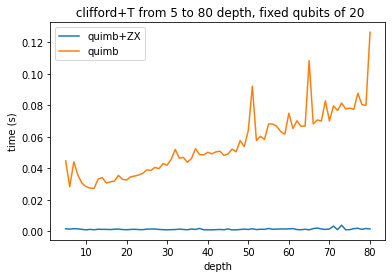

In [24]:
circuits = ['clifford+T']
cb = CircuitBenchmark(10, circuits)
cb.test(varying='depth', fixed_quant = 20, range = range(5, 81))

Average improvement: 49.21734871652155


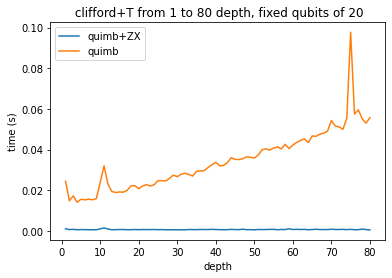

In [13]:
circuits = ['clifford+T']
cb = CircuitBenchmark(10, circuits)
cb.test(varying='depth', fixed_quant = 20, range = range(5, 81))

## Full reduce

Average improvement: 5.9686638577801485
Average improvement: 5.95581598698322


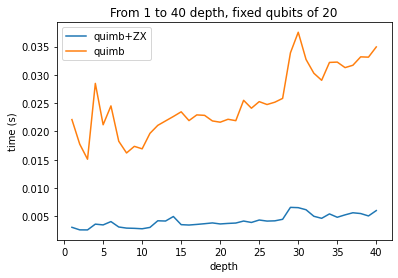

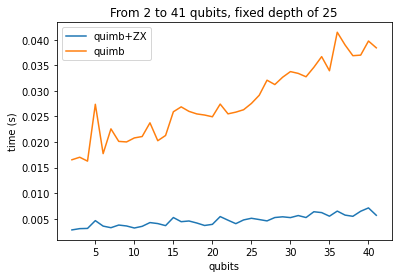

In [82]:
cb = CircuitBenchmark(3, 'clifford+T')
cb.test(varying='depth', fixed_quant = 20, range = range(1, 41))
cb.test(varying = 'qubits', fixed_quant = 25, range = range(2, 42))

Average improvement: 5.308235300492593
Average improvement: 5.871573417324676


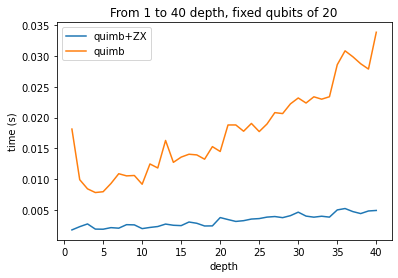

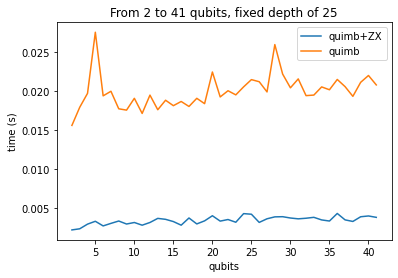

In [86]:
cb = CircuitBenchmark(3, 'CNOT_HAD_PHASE')
cb.test(varying='depth', fixed_quant = 20, range = range(1, 41))
cb.test(varying = 'qubits', fixed_quant = 25, range = range(2, 42))

## Full reduce + Hyperpivot

Average improvement: 5.831369193653785
Average improvement: 6.249867326443612


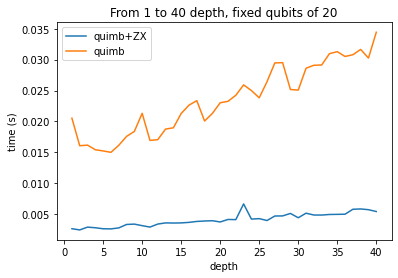

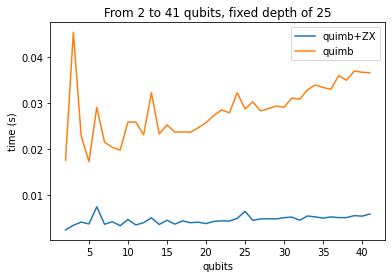

In [88]:
cb = CircuitBenchmark(3, 'clifford+T')
cb.test(varying='depth', fixed_quant = 20, range = range(1, 41))
cb.test(varying = 'qubits', fixed_quant = 25, range = range(2, 42))

Average improvement: 5.276939695015929
hpivot: 1.  1 iterations
par_hbox_simp: 2.  1 iterations
Average improvement: 5.550449945486638


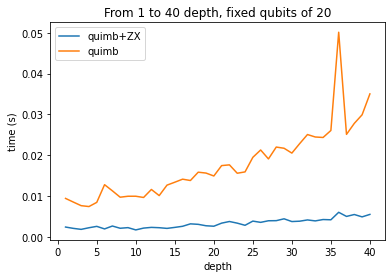

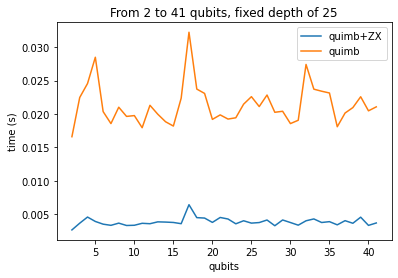

In [89]:
cb = CircuitBenchmark(3, 'CNOT_HAD_PHASE')
cb.test(varying='depth', fixed_quant = 20, range = range(1, 41))
cb.test(varying = 'qubits', fixed_quant = 25, range = range(2, 42))

## Full reduce + Hyperpivot + Fourier Transform

Average improvement: 5.689093156558808
Average improvement: 5.840833286352089


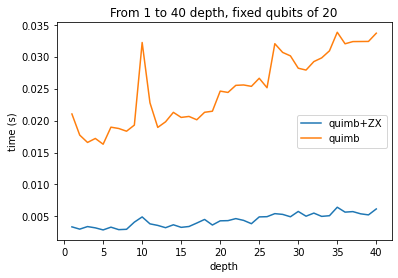

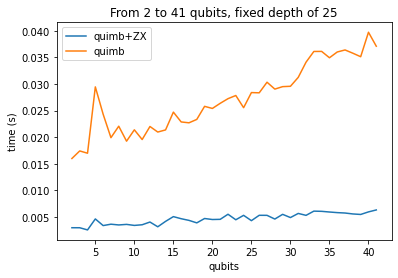

In [91]:
cb = CircuitBenchmark(3, 'clifford+T')
cb.test(varying='depth', fixed_quant = 20, range = range(1, 41))
cb.test(varying = 'qubits', fixed_quant = 25, range = range(2, 42))

Average improvement: 5.01323061877902
Average improvement: 6.0937103696714505


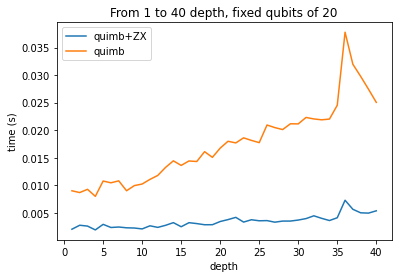

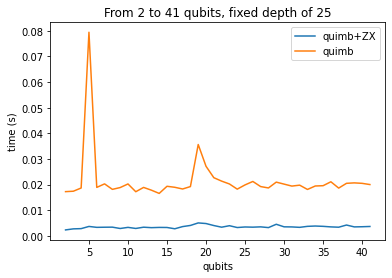

In [94]:
cb = CircuitBenchmark(3, 'CNOT_HAD_PHASE')
cb.test(varying='depth', fixed_quant = 20, range = range(1, 41))
cb.test(varying = 'qubits', fixed_quant = 25, range = range(2, 42))